<a href="https://colab.research.google.com/github/yjmark/Remote-sensing/blob/main/assignments/HW2_Jun_Youngsang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 2: Supervised Land Use Classification with Google Earth Engine

March 6, 2025 | MUSA 6500

Jun, Youngang <br> Student of Master of Urban Spatial Analytics Program <br> University of Pennsylvania



### 1. Data Exploration

In this assignment, I used **USGS Landsat 8 Level 2, Collection 2, Tier 1** image of **San Francisco, CA** as a region of interest (ROI), where an urban area large enough with a sufficient sample size but not so large to save time to process. I filtered images **from January 1, 2023 to December 31, 2023**, and whose **cloud cover is below 10%** and selected the first image.

In [51]:
import geemap
import ee
import geopandas as gpd
from google.colab import drive
import pandas as pd
import numpy as np
import json



# Authenticate and initialize Google Earth Engine, and set Google Drive location
ee.Authenticate()
ee.Initialize(project='yjmark-rs')
drive.mount('/content/drive')

# Define San Francisco area
san_francisco = ee.Geometry.Polygon([
    [[-123.173825, 37.639830], [-122.281780, 37.639830],
     [-122.281780, 37.929824], [-123.173825, 37.929824]]
])

# Load data for Landsat 8 Collection 2 Tier 1 Level 2
dataset = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
  .filterDate('2023-01-01', '2023-12-31') \
  .filterBounds(san_francisco) \
  .filter(ee.Filter.lt('CLOUD_COVER', 10)) # Filter cloud cover is below 10%

# Applies scaling factors.
def apply_scale_factors(image):
  optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
  return image.addBands(optical_bands, None, True).addBands(
      thermal_bands, None, True
  )

dataset = dataset.map(apply_scale_factors)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Data Collection and Feature Engineering

#### 2.1. Collecting and Labeling Training Data

I firstly visualized the image with the condition that **red**, **green**, and **blue** (`SR_B4`,`SR_B3`, and `SR_B2`, respectively) and set each of the minimum value as `0` and the maximum value as `0.3`.

Using the **geometry imports** function in the Google Earth Engine Code Editor, I created **113 polygon samples** for each of the following four classes: **urban**, **bare**, **water**, and **vegetation**. I assigned each class a unique label as the following:
- 0 for urban;
- 1 for bare;
- 2 for water; and
- 3 for vegetation.

I merge the labeled samples into a single GeoJSON dataset, `featuretest3.geojson` and saved in local folder (in my Google Drive).

In [52]:
# Load sample
geojson_path = "/content/drive/My Drive/Colab Notebooks/featuretest3.geojson"
feature_collection = geemap.geojson_to_ee(geojson_path)

# Define a function to color each class differently
def apply_style(feature):
    return feature.set("style", {"color": feature.get("color"), "width": 2})

# Apply styling to each feature
styled_fc = feature_collection.map(apply_style)

# Define Visualization Parameters
visualization = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'], # Red, Green, Blue
    'min': 0.0,
    'max': 0.3,
}

# Create map
m = geemap.Map()
m.set_center(-122.4194, 37.7749, 13)
m.add_layer(dataset, visualization, 'True Color (432)')
m.add_layer(styled_fc.style(**{"styleProperty": "style"}), {}, "Styled GeoJSON")

# Print map
m

Map(center=[37.7749, -122.4194], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

In [53]:
# ✅ 1. RGB(위성 데이터) 선택 (Landsat 8 예시)
rgb_image = dataset.select(['SR_B4', 'SR_B3', 'SR_B2'])  # Red, Green, Blue

# ✅ 2. Styled GeoJSON을 래스터로 변환 (벡터 → 래스터)
vector_raster = styled_fc.reduceToImage(
    properties=['color'],  # 벡터 스타일에서 'color' 속성 사용
    reducer=ee.Reducer.first()
).toByte()  # 8-bit 변환

# ✅ 3. RGB + Styled 레이어 결합
combined_image = ee.Image.cat([rgb_image, vector_raster])

# ✅ 4. GeoTIFF 내보내기 설정
task = ee.batch.Export.image.toDrive(
    image=combined_image,
    description='Sample',
    folder='Colab Notebooks',  # Google Drive 저장 폴더
    fileNamePrefix='Sample',
    scale=30,  # 30m 해상도
    region=ee.Geometry.Point([-122.4194, 37.7749]).buffer(10000).bounds(),  # 전체 영역
    maxPixels=1e13,  # 최대 픽셀 수
    fileFormat='GeoTIFF'
)

task.start()

#### 2.2. Feature Engineering

For possible use in the model, I calculated and added the following spectral indices:

- NDVI (Normalized Difference Vegetation Index)
- NDBI (Normalized Difference Built-up Index)
- MNDWI (Modified Normalized Difference Water Index)

Additionally, using `USGS/SRTMGL1_003` imagery and the function `ee.Terrain.slope()`, I visualized elevation and computed slope data from a DEM. I normalized all image bands to a 0 to 1 scale for consistent model input.

The final merged image is defined as `final_image`.

In [54]:
# Select the first image for visualization
image = dataset.first()

# Load SRTM DEM for elevation data
dem = ee.Image("USGS/SRTMGL1_003")  # 30m resolution
slope = ee.Terrain.slope(dem)  # Compute slope

# Compute NDVI, NDBI, MNDWI
ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
ndbi = image.normalizedDifference(['SR_B6', 'SR_B5']).rename('NDBI')
mndwi = image.normalizedDifference(['SR_B3', 'SR_B6']).rename('MNDWI')

# Normalize function (Min-Max Scaling)
def normalize_band(image, band_name):
    min_val = ee.Number(image.reduceRegion(
        reducer=ee.Reducer.min(),
        geometry=san_francisco,
        scale=30,
        bestEffort=True
    ).get(band_name))
    max_val = ee.Number(image.reduceRegion(
        reducer=ee.Reducer.max(),
        geometry=san_francisco,
        scale=30,
        bestEffort=True
    ).get(band_name))
    normalized = image.expression(
        "(b - min) / (max - min + 1e-6)",  # Small value added to avoid division by zero
        {'b': image.select(band_name), 'min': min_val, 'max': max_val}
    ).rename(band_name + "_norm")
    return normalized

# Select image bands & normalize them
bands = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6']  # Blue, Green, Red, NIR, SWIR1
normalized_bands = [normalize_band(image, b) for b in bands]

# Normalize DEM and slope
elevation_norm = normalize_band(dem, 'elevation')
slope_norm = normalize_band(slope, 'slope')

# Combine all bands
final_image = image.addBands(normalized_bands) \
    .addBands([ndvi, ndbi, mndwi, elevation_norm, slope_norm])

# Define Visualization Parameters
ndvi_vis = {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}
ndbi_vis = {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'red']}
mndwi_vis = {'min': -1, 'max': 1, 'palette': ['black', 'white', 'blue']}
elevation_vis = {'min': 0, 'max': 1, 'palette': ['black', 'white']}
slope_vis = {'min': 0, 'max': 1, 'palette': ['black', 'white']}

# Create map
m = geemap.Map()
m.set_center(-122.4194, 37.7749, 13)
m.add_layer(dataset, visualization, 'True Color (432)')
m.addLayer(final_image.select('NDVI'), ndvi_vis, 'NDVI')
m.addLayer(final_image.select('NDBI'), ndbi_vis, 'NDBI')
m.addLayer(final_image.select('MNDWI'), mndwi_vis, 'MNDWI')
m.addLayer(final_image.select('elevation_norm'), elevation_vis, 'Elevation (Normalized)')
m.addLayer(final_image.select('slope_norm'), slope_vis, 'Slope (Normalized)')
m.add_layer(styled_fc.style(**{"styleProperty": "style"}), {}, "Styled GeoJSON")

# Print map
m

Map(center=[37.7749, -122.4194], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

### 3. Model Training and Evaluation

#### 3.1. Model Training

The current GeoJSON sample dataset contains around 25 polygon samples per class merged into a single multi-polygon. That is, there are 4 multi-polygons as 4 classes in a sample dataset. Instead of this, those multi-polygons needed to be split into a total of 113 individual polygon objects. The following code chunk accomplishes this, and its output is `featuretest3_fixed.geojson`.

In [55]:
import json
import geopandas as gpd
from shapely.geometry import shape, Polygon, MultiPolygon
from shapely.validation import make_valid

# Load GeoJSON file
geojson_path = "/content/drive/My Drive/Colab Notebooks/featuretest3.geojson"  # Replace with your actual file path
with open(geojson_path, "r", encoding="utf-8") as f:
    data = json.load(f)

# Fix invalid geometries and split MultiPolygons
fixed_features = []
for feature in data["features"]:
    geom = shape(feature["geometry"])  # Convert to Shapely geometry
    if not geom.is_valid:
        geom = make_valid(geom)  # Fix invalid geometries
    new_properties = {"classno": feature["properties"].get("classno", None)}  # Extract only the "classno" property, if it exists

    # If it's a MultiPolygon, split into individual Polygons
    if isinstance(geom, MultiPolygon):
        for poly in geom.geoms:
            new_feature = {
                "type": "Feature",
                "geometry": json.loads(json.dumps(poly.__geo_interface__)),  # Convert to GeoJSON format
                "properties": new_properties
            }
            fixed_features.append(new_feature)
    else:
        new_feature = {
            "type": "Feature",
            "geometry": json.loads(json.dumps(geom.__geo_interface__)),
            "properties": new_properties
        }
        fixed_features.append(new_feature)

# Save the cleaned GeoJSON
output_path = "/content/drive/My Drive/Colab Notebooks/featuretest3_fixed.geojson"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump({"type": "FeatureCollection", "features": fixed_features}, f, indent=2)

Split GeoJSON is defined as `feature_collection`, and I joined it with `final_image`. Then I rasterized the class labels from `feature_collection` into an `ee.Image`. The result image of its visualization is as follows.


In [56]:
feature_collection = geemap.geojson_to_ee(output_path)

# Converted class number (classno) into float
feature_collection = feature_collection.map(lambda f: f.set({
    "classno": ee.Number.parse(f.get("classno")),
}))

# Assigned class labels to pixels
class_image = feature_collection.reduceToImage(
    properties=['classno'],
    reducer=ee.Reducer.first()
).rename('classno')

# Combined class labels with final_image
final_image_with_class = final_image.addBands(class_image)

# Visualization
vis_params = {
    "min": 0, "max": 3,  # Assuming class numbers 0 to 3
    "palette": ["red", "yellow", "blue", "green"]  # 0: Urban, 1: Bare, 2: Water, 3: Vegetation
}

# Displayed in Map
m = geemap.Map()
m.set_center(-122.4194, 37.7749, 13)
m.addLayer(final_image, {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.3}, "True Color")
m.addLayer(final_image_with_class.select('classno'), vis_params, "Class Labels")
m

Map(center=[37.7749, -122.4194], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

#### 3.2. Accuracy Assessment

After converted all pixel in `final_image_with_class` into dataframe (`df`), I split the data into a **training dataset** (70%) and a **validation dataset** (30%). I trained and evaluated a **random forest model** using the training set with all engineered features.

The importance of `MNDWI`, `NDVI`, and normalized elevation (`elevation_norm`) are greater than 0.1, which are significantly influential for classfication.

The overall accuracy of the model is 99.14%, which represents that the model is overfitted. Precision (True Positives over (True Positives + False Positives), i.e. true positives among predicted positives) and recall (True Positives over (True Positives + False Negatives), i.e. true positives among actual positives) are as follows. The lowest recall is class 1 (bare), and it may be because the area of each sample is significantly smaller than other classes (water, vegetation, and urban).

Model Accuracy: 0.9914

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       330
           1       1.00      0.88      0.94        33
           2       1.00      1.00      1.00       349
           3       0.99      1.00      0.99       218

    accuracy                           0.99       930
   macro avg       0.99      0.97      0.98       930
weighted avg       0.99      0.99      0.99       930


Feature Importance:
           Feature  Importance
2             NDVI    0.146192
0            MNDWI    0.121386
27  elevation_norm    0.106386
19          ST_B10    0.074597
15      SR_B6_norm    0.056499
12           SR_B5    0.052750
25         ST_TRAD    0.044527
23         ST_EMSD    0.040672
7       SR_B2_norm    0.037816
13      SR_B5_norm    0.035391
6            SR_B2    0.029911
10           SR_B4    0.027977
14           SR_B6    0.027007
11      SR_B4_norm    0.024235
22         ST_EMIS    0.022048


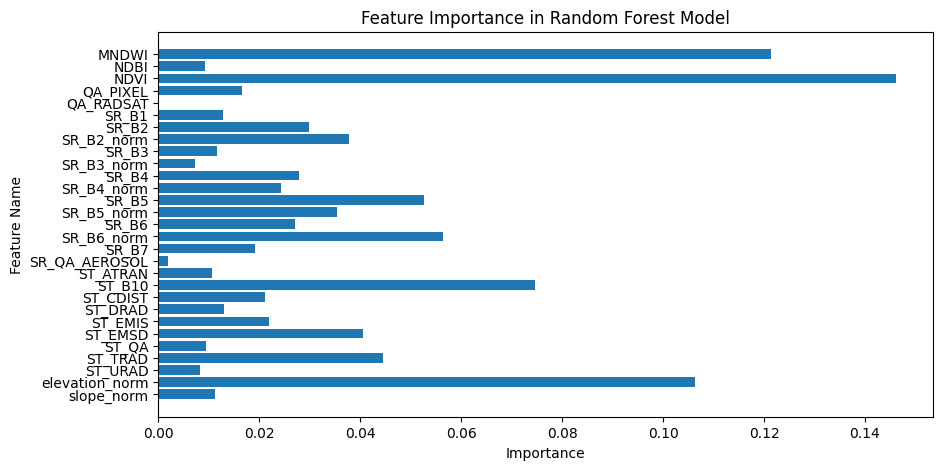

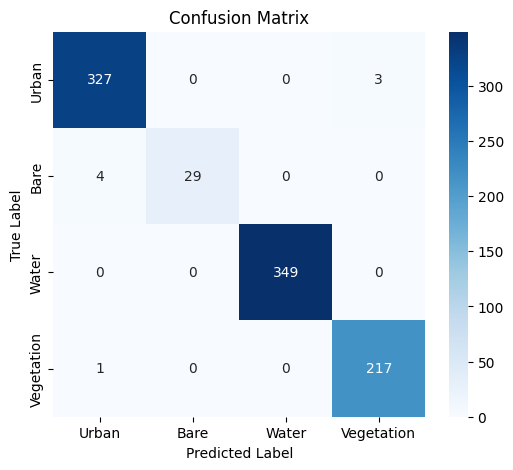

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Sampled all pixels in `final_image_with_class`
samples = final_image_with_class.sampleRegions(
    collection=final_image_with_class.geometry(),
    scale=30,  # Resolution: 30m
    geometries=True,
    tileScale=2
)

# Convert samples to a dataframe
df = geemap.ee_to_df(samples)

# Separate feature and label
feature_columns = [col for col in df.columns if col not in ['classno', 'longitude', 'latitude']]
X = df[feature_columns]  # Feature matrix
y = df['classno']  # Class label

# Random split 70% for training data and 30% for validation data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Training via Random Forest and modeling
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prediction and evaluation
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Variable importance scores
feature_importance = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': feature_columns, 'Importance': feature_importance})

# Printed, visualized, and exported variable importance scores
print("\nFeature Importance:")
print(feature_importance_df.sort_values(by='Importance', ascending=False))
feature_importance_df.to_csv("/content/drive/My Drive/Colab Notebooks/feature_importance.csv", index=False)

plt.figure(figsize=(10, 5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature Name")
plt.title("Feature Importance in Random Forest Model")
plt.gca().invert_yaxis()
plt.show()

# Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                     index=['Urban', 'Bare', 'Water', 'Vegetation'],
                     columns=['Urban', 'Bare', 'Water', 'Vegetation'])

# Printed, visualized, and exported confusion matrix
cm_df.to_csv("/content/drive/My Drive/Colab Notebooks/confusion_matrix.csv")

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Urban', 'Bare', 'Water', 'Vegetation'], yticklabels=['Urban', 'Bare', 'Water', 'Vegetation'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The following map is the predicted land cover classification image using the trained random forest model.

In [58]:
trained_classifier = ee.Classifier.smileRandomForest(100).train(samples, 'classno', feature_columns)
predicted_image = final_image_with_class.select(feature_columns).classify(trained_classifier)

vis_params = {
    "min": 0, "max": 3,
    "palette": ["red", "yellow", "blue", "green"]  # 0: Urban, 1: Bare, 2: Water, 3: Vegetation
}

m = geemap.Map()
m.set_center(-122.4194, 37.7749, 13)
m.addLayer(final_image_with_class, {'bands': ['SR_B4', 'SR_B3', 'SR_B2'], 'min': 0, 'max': 0.3}, "True Color")
m.addLayer(predicted_image, vis_params, "Classified Image")
m

Map(center=[37.7749, -122.4194], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

The following code chunk is to export the map above with the GeoTIFF format.

In [59]:
predicted_image_scaled = predicted_image.multiply(85).toByte()
palette = ee.List([
    [255, 0, 0],    # 0: Urban → Red
    [255, 255, 0],  # 1: Bare → Yellow
    [0, 0, 255],    # 2: Water → Blue
    [0, 255, 0]     # 3: Vegetation → Green
])
predicted_rgb = predicted_image_scaled.visualize(min=0, max=255, palette=palette)
task = ee.batch.Export.image.toDrive(
    image=predicted_rgb,
    description='predicted_image',
    folder='Colab Notebooks',  # Google Drive 저장 폴더
    fileNamePrefix='predicted_image',
    scale=30,  # 30m 해상도
    region=final_image_with_class.geometry().bounds(),  # 전체 영역
    maxPixels=1e13,  # 최대 픽셀 수
    fileFormat='GeoTIFF'
)

task.start()

The land cover classes represented by each color on ESA (European Space Agency)’s WorldCover map (`ESA/WorldCover/v200`) are more subdivided into finer categories than the four types of my landcover data. To match these two, I reclassified the ESA map into four categories, as shown on the map below. For example, Bare/sparse vegetation, Snow and ice classes in the ESA map are reclassified into Bare. Tree cover, Shrubland, Grassland, Cropland, Moss & lichen are reclassified into Vegetation.

When visually comparing my landcover data with the corresponding ESA data, northern and eastern part were similar, while southern and southwestern part were significantly different. It may be because the urban and vegetation samples initially selected were skewed toward the north and east. The water samples were evenly distributed from the north, east, and west of the San Francisco Peninsula.

In [60]:
dataset_ESA = ee.ImageCollection('ESA/WorldCover/v200').first()

# ESA WorldCover classification mapping
remap_dict = {
    50: 0,  # Built-up → Urban
    60: 1, 70: 1,  # Bare/sparse vegetation, Snow and ice → Bare
    80: 2, 90: 2, 95: 2,  # Water bodies, Wetland, Mangrove → Water
    10: 3, 20: 3, 30: 3, 40: 3, 100: 3  # Tree cover, Shrubland, Grassland, Cropland, Moss & lichen → Vegetation
}

# ESA WorldCover reclassification
dataset_ESA_reclassified = dataset_ESA.remap(
    list(remap_dict.keys()),
    list(remap_dict.values())
)

ESA_vis = {
  'bands': ['Map']
}

vis_params = {
    "min": 0, "max": 3,
    "palette": ["red", "yellow", "blue", "green"]  # 0: Urban, 1: Bare, 2: Water, 3: Vegetation
}

m = geemap.Map()
m.set_center(-122.4194, 37.7749, 13)
m.addLayer(dataset_ESA, ESA_vis, 'Landcover')
m.addLayer(dataset_ESA_reclassified, vis_params, "Reclassified ESA Land Cover")
m

Map(center=[37.7749, -122.4194], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

###4. Reflection Questions

1. What limitations did you run into when completing this assignment? What might you do differently if you repeated it, or what might you change if you had more time and/or resources?

  - The results might have less limitation if I could repeat the training in condition that area of each sample had been constant for each class during sampling and the spatial distribution had been evenly located across classes.

  - In the current model, the water class, which was easy to polygon-based sample, had a large sample area, whereas the bare class, which was more challenging to sample, had a smaller sample area.

  - Another limitation is that the urban, vegetation, and bare classes were not evenly sampled across the spatial distribution but were instead concentrated in specific areas.

2. What was the impact of feature engineering? Which layers most contributed to the model? Did you expect this? Why or why not?

  - In addition to RGB images, class distinctions were expected to be more accurate with additional bands such as infrared, altitude, and slope, and I could get the actual model appears to have operated in this way.

  - For example, NDVI can effectively distinguish vegetation by utilizing infrared (B5) and the red band (B4), and it can even assess vegetation health, making it useful for agricultural applications. Similarly, MNDWI can easily identify water bodies by using the green band (B3) and shortwave infrared (SWIR, B6).

  - With the variable importance scores, I can conclude that the importance of MNDWI, NDVI, and normalized elevation (elevation_norm) are greater than 0.1, which are significantly influential for classfication.

3. Did you find it difficult to create the training data by hand? Did you notice any issues with class imbalance? If so, how might you resolve this in the future (hint: consider a different sampling technique).

  - Although I initially trained using RGB images by hand, I could also visually train with NDVI or MNDWI images.

  - External data, such as ESA land cover maps, can also be used for training.

  - Another approach is to use satellite images with higher spectral resolution (even sacrifice  spatial resolution) to incorporate more layers.

4. Did your model perform better on one class than another? Why? Can you think of a reason that this might be good or bad depending on the context?

  - As seen in the confusion matrix, this model is overfitted, which limits its ability to determine whether one class performs better than another. However, the Bare class, which had a small area during sampling, clearly struggled with classification, while the Water class, which covered a relatively large area and had relatively uniform spectral characteristics, had strong classification performance. Vegetation and urban areas also showed good classification performance, though lower than the Water class, due to their having less consistent spectral characteristics and complex spatial distribution.